In [1]:
import pandas as pd
import numpy as np
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
import random
from sklearn.metrics import jaccard_score
from tqdm import tqdm

In [2]:
# import data
data_dict = pd.read_csv('online_boundary_data.csv')

# import story boundary files
directory_stories = '../story_csv'

filenames_stories = glob.glob(directory_stories + '/*.csv')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_csv(filename))

In [10]:
# Processing the keypresses
# Group similarly primed participants for each story
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for i in range(len(data_dict)):
    this_story = data_dict.iloc[i]['story']
    keys = np.array([int(p) for p in list(data_dict.iloc[i]['story_presses'])])
    p_type = data_dict.iloc[i]['p_type']
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 'np':
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 'loc':
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 'soc':
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]
            
# convert keypresses from '9's and '1's to '1's and '0's
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   
    
# Remove first sentence (first row) from all keypresses
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

In [11]:
# Jaccard Analysis

# Creating participant x sentence array for each story
# Organized in following order: no-prime, location, social
keypress_array = {}
summary_vals = {}

for key in all_keys:
    # Index keypresses for each story
    none = none_keys[key].T
    n_none, y = none.shape
    loc = loc_keys[key].T
    n_loc, y = none.shape
    soc = soc_keys[key].T
    n_soc, y = none.shape
    # Concatening keypresses
    final = np.concatenate((none,loc,soc), axis = 0)
    # Putting the final array in a dictionary
    keypress_array[key] = final
    # Putting summary vals together
    summary_vals[key] = np.array([n_none, n_loc, n_soc])
    
# Jaccard Analysis: creating participant x participant matrix of comparison
jc_array = {}

for key in keypress_array:
    n, y  = keypress_array[key].shape
    this_array = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            this_score = jaccard_score(keypress_array[key][i], keypress_array[key][j])
            this_array[i,j] = this_score
    jc_array[key] = this_array

In [12]:
# Binning the comparisons(NP-NP, NP-LOC, NP-SOC, etc)
# Making the mask for each type of bin

# assign a value to each participant based on their priming
colored_arrays = {}

for key in all_keys:
    # Index keypresses for each story
    none = none_keys[key].T
    none_c = copy.deepcopy(none)
    none_c[none >= 0] = 3
    loc = loc_keys[key].T
    loc_c = copy.deepcopy(loc)
    loc_c[loc >= 0] = 5
    soc = soc_keys[key].T
    soc_c = copy.deepcopy(soc)
    soc_c[soc >= 0] = 7
    # Concatening keypresses and storing
    colored_arrays[key] = np.concatenate((none_c,loc_c,soc_c), axis = 0)

# multiply the participants together to get unique vales for each type of comparison type
mask = {}

for key in colored_arrays:
    x, y = colored_arrays[key].shape
    this_array = np.zeros((x, x))
    for i in range(0,x):
        for j in range(0, x):
            first = np.amax(colored_arrays[key][i])
            second = np.amax(colored_arrays[key][j])
            mult = first*second
            this_array[i,j] = mult
    # Putting filled in array in dict
    mask[key] = this_array

In [17]:
# Permuting by shuffling rows and columns of jc_array and binning
np.random.seed(0)
N_perms = 10001
all_perms = np.zeros((3,3,0))
sim_vals = []
diag_vals = []

for this_perm in tqdm(range(0, N_perms)):
    if this_perm == 0:
        rp_jc_array = jc_array.copy()
    else:
        ## permute the rows and columns of jc_array to randomize the binning of jaccard indices
        rp_jc_array = {}
        for key in all_keys:
            # Deep copy the original array
            this_array = np.copy(jc_array[key])
            # Generate a permutation
            this_perm = np.random.permutation(this_array.shape[0])
            # Permute the columns
            this_array = this_array[:, this_perm]
            # Permute the rows
            this_array = this_array[this_perm, :]
            # Put in Dictionary
            rp_jc_array[key] = this_array

    j_bins = {}

    for key in rp_jc_array:
        this_jbin = np.zeros((3,3))
        ######## NP - NP
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '9's
        this_mask[this_mask != 9] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '9's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # sum values and count
        this_sum = np.sum(masked_array)
        count = np.count_nonzero(masked_array)
        # Putting the average masked value in this_jbin
        this_jbin[0,0] = this_sum/count
        ######## NP - loc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '15's
        this_mask[this_mask != 15] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '15's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # sum values and count
        this_sum = np.sum(masked_array)
        count = np.count_nonzero(masked_array)
        # Putting the average masked value in this_jbin
        this_jbin[0,1] = this_sum/count
        this_jbin[1,0] = this_sum/count
        ######## NP - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '21's
        this_mask[this_mask != 21] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '21's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # sum values and count
        this_sum = np.sum(masked_array)
        count = np.count_nonzero(masked_array)
        # Putting the average masked value in this_jbin
        this_jbin[0,2] = this_sum/count
        this_jbin[2,0] = this_sum/count
        ######## loc - loc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '25's
        this_mask[this_mask != 25] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '25's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # sum values and count
        this_sum = np.sum(masked_array)
        count = np.count_nonzero(masked_array)
        # Putting the average masked value in this_jbin
        this_jbin[1,1] = this_sum/count
        ######## loc - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '35's
        this_mask[this_mask != 35] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '35's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # sum values and count
        this_sum = np.sum(masked_array)
        count = np.count_nonzero(masked_array)
        # Putting the average masked value in this_jbin
        this_jbin[1,2] = this_sum/count
        this_jbin[2,1] = this_sum/count
        ######## soc - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '49's
        this_mask[this_mask != 49] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '49's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * rp_jc_array[key]
        # sum values and count
        this_sum = np.sum(masked_array)
        count = np.count_nonzero(masked_array)
        # Putting the average masked value in this_jbin
        this_jbin[2,2] = this_sum/count
        #######################################################################
        # Put this_jbin in j_bins dict
        j_bins[key] = this_jbin
        
    # Average across stories
    # Concatenate Matrices along the third dimension
    all_j_bins = np.zeros((3,3,0))
    for key in j_bins:
        all_j_bins = np.dstack((all_j_bins, j_bins[key]))

    avg_all_j_bins = np.nanmean(all_j_bins, axis = 2)
    all_perms = np.dstack((all_perms, avg_all_j_bins))
        
    # Calculate similarity values and append
    sim_vals.append(((avg_all_j_bins[1,1] + avg_all_j_bins[2,2])/2) - avg_all_j_bins[1,2])
    
    # Putting diagonal values into a list
    for i in range(0,3):
        diag_vals.append(avg_all_j_bins[i,i])

100%|████████████████████████████████████| 10001/10001 [00:45<00:00, 217.65it/s]


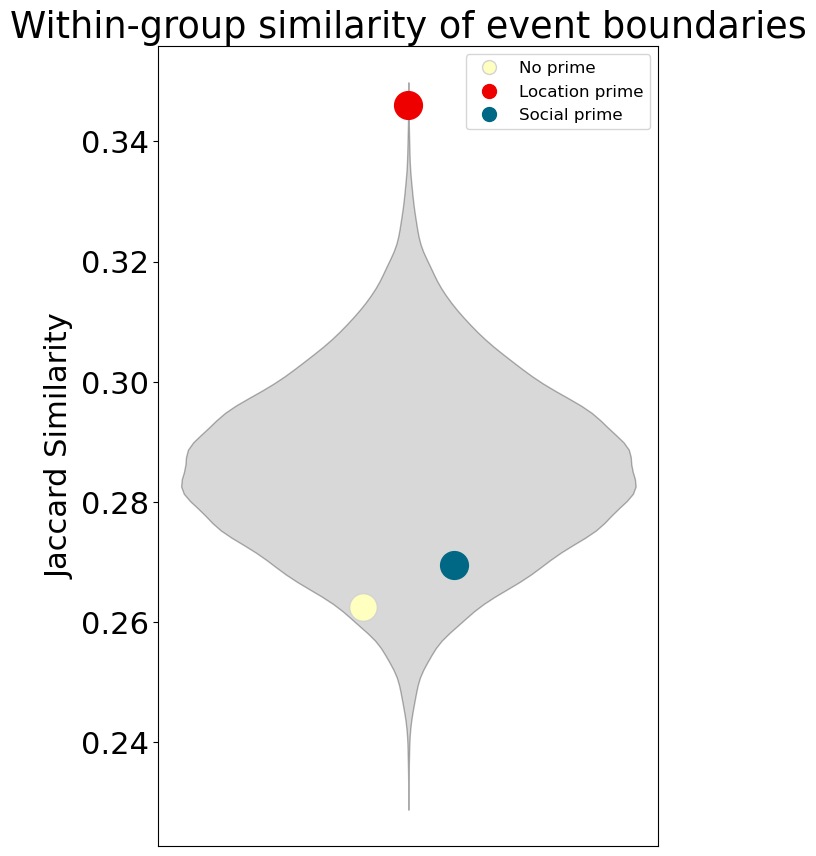

In [19]:
# Paper Fig - Violin Plot
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [5, 8]
# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Jaccard Similarity')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax.plot(.95, all_perms[0,0,0], marker="o", markersize=20, markeredgecolor='#d3d3d3', markerfacecolor='#ffffbf', linestyle="None")
ax.plot(1, all_perms[1,1,0], marker="o", markersize=20, markeredgecolor='#ee0000', markerfacecolor='#ee0000', linestyle="None")
ax.plot(1.05, all_perms[2,2,0], marker="o", markersize=20, markeredgecolor='#006884', markerfacecolor='#006884', linestyle="None")


bp = ax.violinplot(diag_vals)
for pc in bp['bodies']:
    pc.set_facecolor('#808080')
    pc.set_edgecolor('black')
    pc.set_alpha(.3)
    
for partname in ('cbars','cmins','cmaxes'):
    vp = bp[partname]
    vp.set_edgecolor('#808080')
    vp.set_linewidth(0)
    
#ax.legend((rects1[0], rects2[0], rects3[0]), ('No Prime', 'Location', 'Social'))
ax.legend(['No prime', 'Location prime', 'Social prime'], loc='upper right', fontsize = '12', markerscale=.5)
ax.set_title('Within-group similarity of event boundaries')
plt.show()

In [20]:
p = ((diag_vals >= all_perms[1,1,0]).sum())/(N_perms*3)
print('p (location priming)=',p)

p (location priming)= 9.999000099990002e-05


In [21]:
p = ((diag_vals >= all_perms[2,2,0]).sum())/(N_perms*3)
print('p (social priming)=',p)

p (social priming)= 0.8599473385994734
